In [1]:
from qiskit.circuit.library import TwoLocal, CXGate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.measure_all()

In [2]:
from lib.greedy_circs import *
import qiskit 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import CXGate
import numpy as np
from lib.dvr1d import *
from lib.utils import *
from lib.vqe import DVR_VQE
from lib.pot_gen import get_pot_cr2

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options
from qiskit.tools.visualization import plot_histogram

service = QiskitRuntimeService(
    channel='ibm_quantum',
    token='50e4f60f02cd247a763d93cbeb949668b4383e6df68ba8a7b4c97b35be7d9cf41f83566cb249b7619d46f081d8349d911392a9d12def4088966310b9168a7f10'
)

backend = service.get_backend('ibmq_qasm_simulator')

options = Options(optimization_level=2, resilience_level=2)
cnot = transpile(qc, basis_gates=['ecr', 'rz', 'x', 'sx', 'id'])
result = backend.run(cnot).result()
count = result.get_counts(cnot)
execution_time = result.time_taken 
plot_histogram(count, title='Bell-State counts')
print(execution_time)

KeyboardInterrupt: 

In [4]:
qc_ecr = QuantumCircuit(2)
qc_ecr.ecr(0,1)
qc_ecr.measure_all()
options = Options(optimization_level=2, resilience_level=2)
ecr = transpile(qc_ecr, basis_gates=['ecr', 'rz', 'x', 'sx', 'id'])
result = backend.run(ecr).result()
count = result.get_counts()
execution_time = result.time_taken 
print(execution_time)

NameError: name 'backend' is not defined

In [ ]:
ecr.draw()

┌──────┐ ░ ┌─┐   
   q_0: ┤0     ├─░─┤M├───
        │  Ecr │ ░ └╥┘┌─┐
   q_1: ┤1     ├─░──╫─┤M├
        └──────┘ ░  ║ └╥┘
meas: 2/════════════╩══╩═
                    0  1

In [ ]:
cnot.draw()

global phase: π/2
        ┌──────────┐                ┌──────┐┌───┐ ░ ┌─┐   
   q_0: ┤ Rz(-π/2) ├────────────────┤0     ├┤ X ├─░─┤M├───
        └┬────────┬┘┌────┐┌────────┐│  Ecr │└───┘ ░ └╥┘┌─┐
   q_1: ─┤ Rz(-π) ├─┤ √X ├┤ Rz(-π) ├┤1     ├──────░──╫─┤M├
         └────────┘ └────┘└────────┘└──────┘      ░  ║ └╥┘
meas: 2/═════════════════════════════════════════════╩══╩═
                                                     0  1

In [14]:
circuit = QuantumCircuit(1)
circuit.ry(Parameter('theta'), 0)
rz_basis = transpile(circuit, basis_gates=['rz', 'sx'])


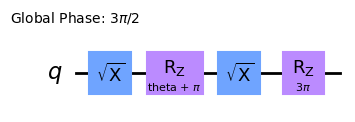

In [15]:
rz_basis.draw(output='mpl')

In [41]:
check = QuantumCircuit(3)
def phase_shift(quantum_circuit, lam, qubit):
    quantum_circuit.p(lam, qubit)
    quantum_circuit.x(qubit)
    quantum_circuit.p(lam, qubit)
    quantum_circuit.x(qubit)
    
phase_shift(check, 3*np.pi/2, 0)

check.rz(Parameter('theta_1'), 0)
check.x(0)

phase_shift(check, 3*np.pi/2, 1)
check.rz(Parameter('theta_2'), 1)
check.x(1)

phase_shift(check, 3*np.pi/2, 2)
check.rz(Parameter('theta_3'), 2)
check.x(2)

rz= transpile(check, basis_gates=['ry','cx'])
rz.draw(output='mpl')

TranspilerError: "Unable to translate the operations in the circuit: ['rz', 'x', 'p'] to the backend's (or manually specified) target basis: ['measure', 'snapshot', 'cx', 'barrier', 'delay', 'reset', 'ry']. This likely means the target basis is not universal or there are additional equivalence rules needed in the EquivalenceLibrary being used. For more details on this error see: https://docs.quantum-computing.ibm.com/api/qiskit/qiskit.transpiler.passes.BasisTranslator#translation-errors"

In [43]:
from lib.greedy_circs import *

import numpy as np
from lib.dvr1d import *
from lib.utils import *
from lib.vqe import DVR_VQE
from lib.pot_gen import get_pot_cr2

# 16 points
params16 = [5.2, 9]
dvr_options = {
    'type': '1d',
    'box_lims': (params16[0], params16[1]),
    'dx': (params16[1] - params16[0]) / 16,
    'count': 16
}

ansatz_options_list = [{
    'type': 'greedyent',
    'constructive': True,
    'layers': 6 * reps,
    'num_keep': 1, 
    'num_qubits': 4,
    'reps': reps,
    'partitions': [[0,1,2,3,4,5]]
} for reps in [1, 2, 3]]

vqe_options = {
    'optimizers': ['L_BFGS_B.80000', 'SLSQP.1000', 'UMDA.25'],
    'repeats': 5, 
    'seed': 42
}

mol_params = cr2_params
spin = 13
mol_params['name'] += f'_{spin}'

pot, lims = get_pot_cr2(spin)
dvr_vqe = DVR_VQE(mol_params, pot, log_dir='')
# dvr_vqe = DVR_VQE(mol_params, pot, log_dir=scratch_dir + 'test/')
for ansatz_options in ansatz_options_list:
    dvr_vqe.get_dvr_vqe(dvr_options, ansatz_options, vqe_options, excited_states=False)

[ 2.8  3.2  3.6  4.   4.4  4.8  5.2  5.6  6.   6.4  6.8  7.2  7.6  8.
  9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  22.  24.
 28.  32.  36.  40. ]
[]
Layer 1 ...
--------
     ┌─────────────┐┌───┐┌────────┐ ░ ┌──────┐ ░ ┌─────────────────┐┌───┐»
q_0: ┤ Rz($x_{0}$) ├┤ X ├┤ Rz(3π) ├─░─┤0     ├─░─┤ Rz($x_{4}$ + π) ├┤ X ├»
     ├─────────────┤├───┤├────────┤ ░ │  Ecr │ ░ ├─────────────────┤├───┤»
q_1: ┤ Rz($x_{1}$) ├┤ X ├┤ Rz(3π) ├─░─┤1     ├─░─┤ Rz($x_{5}$ + π) ├┤ X ├»
     ├─────────────┤├───┤├────────┤ ░ └──────┘ ░ └─────────────────┘└───┘»
q_2: ┤ Rz($x_{2}$) ├┤ X ├┤ Rz(3π) ├─░──────────░─────────────────────────»
     ├─────────────┤├───┤├────────┤ ░          ░                         »
q_3: ┤ Rz($x_{3}$) ├┤ X ├┤ Rz(3π) ├─░──────────░─────────────────────────»
     └─────────────┘└───┘└────────┘ ░          ░                         »
«     ┌────────┐
«q_0: ┤ Rz(3π) ├
«     ├────────┤
«q_1: ┤ Rz(3π) ├
«     └────────┘
«q_2: ──────────
«               
«q_3: ──────────
«  

AttributeError: 'NoneType' object has no attribute 'minimize'